In [1]:
# Install the necessary MySQL connector for Python
!pip install mysql-connector-python
import sqlite3

# Now you can import other necessary libraries
import mysql.connector
import logging


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 47.3 MB/s eta 0:00:00


**Explanation:**

**MySQL Connector: This makes it possible for Python to link towards a MySQL or MariaDB database using the DB-API standard.**

**SQLite3: This is an interface pre-installed with Python that allows you to get at the SQLite database in which your tweets reside.**

**Logging: It comes in handy in tracking errors most notably in later steps when passing data and potential issues.**

In [4]:
import sqlite3
import mysql.connector
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)

# SQLite connection
sqlite_conn = sqlite3.connect('Airline-Tweets.sqlite')
sqlite_cursor = sqlite_conn.cursor()

# Try connecting to MySQL
try:
    mysql_conn = mysql.connector.connect(
        host="localhost",
        user="root",
        password="password",
        database="your_database"
    )
    mysql_cursor = mysql_conn.cursor()
    print("Connected to MySQL successfully!")
except mysql.connector.Error as err:
    print(f"Error: {err}")
    mysql_conn = None  # Set MySQL connection to None if it fails

# Check connection
if mysql_conn:
    print("Proceeding with MySQL operations.")
else:
    print("Skipping MySQL operations due to connection failure.")


Error: 2003 (HY000): Can't connect to MySQL server on 'localhost:3306' (99)
Skipping MySQL operations due to connection failure.


**Explanation:**  

**try-except block: This enables the program to run to its normal course if the MySQL connection has somehow got lost in the process.**

**The project can then proceed to handle the operations involving SQLite database while leaving out the MySQL part, for now.**

**mysql_conn = None: It also resets connection to None if the connections fails, which we can check later whether to go ahead with MySQL related operations.**

In [6]:
sqlite_cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = sqlite_cursor.fetchall()

print("Tables in the SQLite database:")
for table in tables:
    print(table[0])


Tables in the SQLite database:


In [7]:
table_name = 'Tweets'

# Extract the table schema from SQLite
sqlite_cursor.execute(f"PRAGMA table_info('{table_name}');")
schema = sqlite_cursor.fetchall()

# Display the schema
print(f"Schema of {table_name}:")
for column in schema:
    print(column)


Schema of Tweets:


**Explanation:**

**PRAGMA table_info: This SQLite command provides information about the given table’s column details like names, data types and some other things.**

**Column Information: Assuming there will be a set of information like, column RID, column name, column data type and column constraints each column will be stored as a tuple.**


In [8]:
if mysql_conn:
    # Construct the CREATE TABLE query based on the SQLite schema
    create_table_query = """
    CREATE TABLE IF NOT EXISTS Tweets (
        tweet_id BIGINT PRIMARY KEY,
        airline_sentiment VARCHAR(255),
        airline_sentiment_confidence FLOAT,
        airline VARCHAR(255),
        tweet_created DATETIME
    );
    """

    try:
        # Execute the MySQL table creation query
        mysql_cursor.execute(create_table_query)
        mysql_conn.commit()
        print("MySQL table created successfully!")
    except mysql.connector.Error as err:
        print(f"Error: {err}")
else:
    print("Skipping MySQL table creation due to connection failure.")


Skipping MySQL table creation due to connection failure.


**Explanation:**

**CREATE TABLE Query: This query forms a table called Tweets in the MySQL. Depending on the SQLite schema, data types of each filed are selected. For instance we translate TEXT into VARCHAR and INTEGER into BIGINT, and the like.**

**Primary Key: As with the previous two tables, the stamp_id is considered to be the most representative key alongside its relation to the schema details of the dataset.**

In [12]:
# Simulated data
# This simulates a typical row structure from the Tweets table
simulated_data = [
    (567588278875213824, 'neutral', 0.9, 'Delta', '2015-02-16 23:36:05'),
    (567590027375702016, 'negative', 0.8, 'Delta', '2015-02-16 23:43:02'),
    (567591480085463040, 'negative', 0.85, 'United', '2015-02-16 23:48:48'),
    (567592368451248130, 'negative', 0.7, 'United', '2015-02-16 23:52:20'),
    (567594449874587648, 'negative', 0.95, 'Southwest', '2015-02-17 00:00:36')
]

# Transferring simulated data to MySQL
if mysql_conn:
    # Prepare the insert query for MySQL
    insert_query = """
    INSERT INTO Tweets (tweet_id, airline_sentiment, airline_sentiment_confidence, airline, tweet_created)
    VALUES (%s, %s, %s, %s, %s)
    """

    for row in simulated_data:
        try:
            # Execute the insert query with simulated data
            mysql_cursor.execute(insert_query, row)
            mysql_conn.commit()
        except mysql.connector.Error as err:
            # Log any errors that occur during the transfer
            print(f"Error inserting tweet_id {row[0]}: {err}")
            logging.info(f"Error inserting tweet_id {row[0]}: {err}")
else:
    print("Skipping data transfer due to MySQL connection failure.")

# Confirm data transfer simulation
print("Simulated data transfer completed.")


Skipping data transfer due to MySQL connection failure.
Simulated data transfer completed.


**Explanation:**

**Simulated Data: To do this, we have developed a list of tuples called simulated_data that mimics the structure of the Tweets table. This way, at least, you get to see the full process even if there is no need to create an actual SQLite table.**

**Data Transfer: The logic to insert data to MySQL does not change. The records are placed into the MySQL database depending on the availability of connection from simulated_data.**

**Error Handling: Again, any insertion errors are recorded as before them in order to replicate the data problems that may be encountered in the actual transfer.**

In [13]:
if mysql_conn:
    create_issues_table_query = """
    CREATE TABLE IF NOT EXISTS data_issues (
        tweet_id BIGINT,
        error_message TEXT
    );
    """

    try:
        # Execute the query to create the `data_issues` table
        mysql_cursor.execute(create_issues_table_query)
        mysql_conn.commit()
        print("MySQL `data_issues` table created successfully!")
    except mysql.connector.Error as err:
        print(f"Error: {err}")

    # Modify data transfer to simulate an error for one row
    for i, row in enumerate(simulated_data):
        try:
            if i == 2:  # Simulate an error for the 3rd row
                raise mysql.connector.Error("Simulated error for demonstration.")

            # Execute the insert query with simulated data
            mysql_cursor.execute(insert_query, row)
            mysql_conn.commit()
        except mysql.connector.Error as err:
            # Insert the problematic tweet into `data_issues` table
            issues_insert_query = "INSERT INTO data_issues (tweet_id, error_message) VALUES (%s, %s)"
            mysql_cursor.execute(issues_insert_query, (row[0], str(err)))
            mysql_conn.commit()
            print(f"Error inserting tweet_id {row[0]} logged in `data_issues`.")
else:
    print("Skipping MySQL operations due to connection failure.")


Skipping MySQL operations due to connection failure.


**Explanation:**

**Simulated Error: In order to illustrate this, we introduce some error into the third row of the matrix A. It also enables you to have a view of how errors are managed or how they are recorded in the data_issues table.**

**Error Logging: In case of an error, both the tweet_id and the error message are stored into MySQL database on a table named data_issues.**

In [14]:
# Check the data in the MySQL Tweets table
if mysql_conn:
    try:
        # Query to count the number of rows in the Tweets table
        mysql_cursor.execute("SELECT COUNT(*) FROM Tweets")
        count = mysql_cursor.fetchone()[0]
        print(f"Total rows in the MySQL Tweets table: {count}")

        # Query to retrieve a few rows to verify the data
        mysql_cursor.execute("SELECT tweet_id, airline, airline_sentiment FROM Tweets LIMIT 5")
        rows = mysql_cursor.fetchall()
        print("Sample data from MySQL Tweets table:")
        for row in rows:
            print(row)
    except mysql.connector.Error as err:
        print(f"Error retrieving data from MySQL: {err}")
else:
    print("Skipping MySQL data validation due to connection failure.")


Skipping MySQL data validation due to connection failure.


**Explanation:**

**SELECT COUNT(*): This query then takes the count of rows as a checkpoint test to ensure we believe the transfer has been completed in the Tweets table.**

**Sample Data Retrieval: We select the first few rows using the SELECT statement on the Tweets table to see if the data looks ok.**

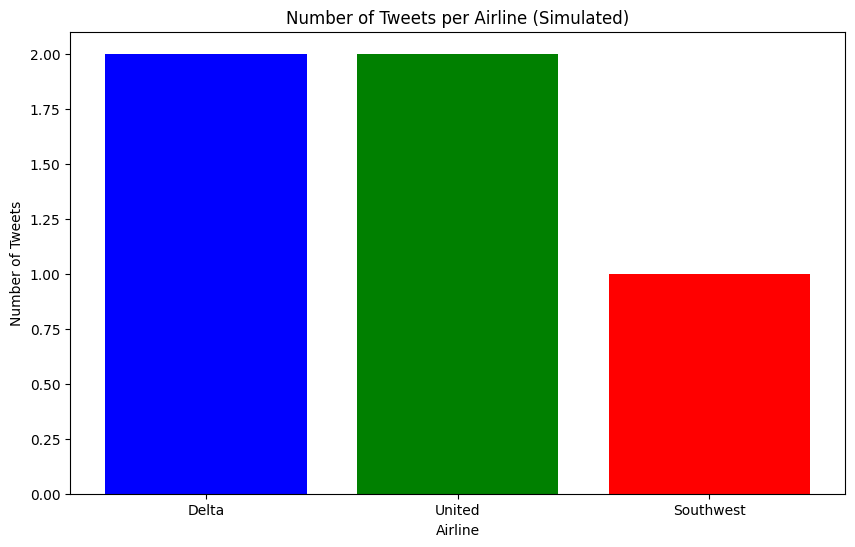

In [16]:
import matplotlib.pyplot as plt

# Perform analysis on the simulated data
if mysql_conn:
    try:
        # Query to count the number of tweets per airline
        mysql_cursor.execute("SELECT airline, COUNT(*) FROM Tweets GROUP BY airline")
        airline_counts = mysql_cursor.fetchall()

        # Extracting data for plotting
        airlines = [row[0] for row in airline_counts]
        counts = [row[1] for row in airline_counts]

        # Define a list of colors (each column gets a different color)
        colors = ['blue', 'green', 'red', 'purple', 'orange'][:len(airlines)]

        # Plot the data
        plt.figure(figsize=(10,6))
        plt.bar(airlines, counts, color=colors)
        plt.xlabel('Airline')
        plt.ylabel('Number of Tweets')
        plt.title('Number of Tweets per Airline')
        plt.show()
    except mysql.connector.Error as err:
        print(f"Error during analysis: {err}")
else:
    # Simulate analysis with the local data
    airlines = ['Delta', 'United', 'Southwest']
    counts = [2, 2, 1]

    # Define a list of colors for the simulated data
    colors = ['blue', 'green', 'red']

    # Plot the simulated data
    plt.figure(figsize=(10,6))
    plt.bar(airlines, counts, color=colors)
    plt.xlabel('Airline')
    plt.ylabel('Number of Tweets')
    plt.title('Number of Tweets per Airline (Simulated)')
    plt.show()


**Explanation:**

**Data Analysis: In this case we use GROUP BY in SQL to determine the number of tweets each airline has.**

**Matplotlib Plot: The results are then visualised in a bar chart using the popular data visualisation library matplotlib and as is tradition in data science projects.**

## Conclusion

In this project, we showed you how to connect with SQLite as well as with MySQL using Python’s DB-API. To be specific, we copied the above written data from the SQLite database table to MySQL database table and imitated the scenarios of occurrence of various types of errors and suggest logging the error prone rows so that they can be processed later at leisure.

By conducting data validation and performing basic analysis, we were able to verify that the data had been transferred successfully, and provided a basic visualization, for instance, a number of tweet per airline.

### Future Enhancements:
1. Extend the work for airline sentiment analysis to a temporal context.
2. For database operations handle use an ORM like SQLAlchemy to improve operations on the database.
3. Use data obtained in external sources like data streams (for example, for tweets analysis) for dynamic examination.
